In [1]:
import numpy as np
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import dill
import sys
sys.path.append('../')
import mg_si.plot as mplt

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
def smooth(x,N=3):
    assert(N%2==1)
    out = np.array(x)
    out[(N-1)//2:-(N-1)//2] = running_mean(x,N)
    return out
def replace_outliers(y, percent=0.2, N=3):
    assert(N%2==1)
    Nends = N-1
    outliers = np.where( np.abs((y[:-Nends]+y[Nends:])/(Nends*y[Nends//2:-Nends//2])-1) > percent)[0]+1
    y2 = np.array(y)
    y2[outliers] = 0.
    for n in range(1,Nends//2+1):
        y2[outliers] += (y[outliers-n]+y[outliers+n])/Nends
    return y2
def remove_outliers(t,y,percent=0.2, N=3):
    Nends = N-1
#     non_outliers = np.where( np.abs((y[:-Nends]+y[Nends:])/(Nends*y[Nends//2:-Nends//2])-1) < percent)[0]+Nends//2
    non_outliers = np.where( np.abs((y[:-Nends]+y[Nends:])/(2*y[Nends//2:-Nends//2]) - 1) < percent)[0]+Nends//2
    return t[non_outliers], y[non_outliers]

In [3]:
def get_all_wtp(basedir, csvfile, solutionfile):
    column_names = ['time', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0', 'MgNumFp', 'MgNumPv', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present', 'deltaT0', 'layer_thickness', 'overturn']
    df = pd.read_csv(basedir+csvfile, names=column_names)
    N = len(df)
    all_wtp = np.zeros((df.shape[0],4))
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
            continue
        pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        all_wtp[i,:] = pl.reactions.core.M2wtp(solution[-1,2:6])
    return all_wtp

def load_all_data_nature(basedir, csvfile, alldatafile='all_parameters.m'):
    all_data = []
    column_names = ['time', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0', 'MgNumFp', 'MgNumPv', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present', 'deltaT0', 'layer_thickness', 'overturn']
    df = pd.read_csv(basedir+csvfile, names=column_names)
    N = len(df)
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+alldatafile):
            continue
        t_N, allp = dill.load(open(basedir+foldername+alldatafile,'rb'))
        allp.Eex = allp.Egm + allp.Egs + allp.Egf
        allp.Eic = allp.Eg + allp.El
        all_data.append((t_N, allp, foldername))
    return all_data

In [4]:
# csvfile = 'ri10p_data.csv'
# csvfile = 'ri05p_data.csv'
csvfile = 'ri05p_data.csv'

alldatafile = 'all_parameters.m'
basedir = '../computed_solutions_nature/'
solutionfile = 'data.m'
all_ents = load_all_data_nature(basedir, csvfile, alldatafile=alldatafile)

# Compute and store entropies in pandas

In [29]:
df05 = pd.read_csv('../computed_solutions_nature/ri05p_l6000K_data.csv', names=['time', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0', 'MgNumFp', 'MgNumPv', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present', 'deltaT0', 'layer_thickness', 'overturn'])

In [30]:
df05.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0,MgNumFp,MgNumPv,X_MgFeO_b,X_SiO2_b,nu_present,deltaT0,layer_thickness,overturn
count,1.155000e+03,1155.000000,1155.000000,1155.000000,1155.000000,1.155000e+03,1155.00,1.155000e+03,1.155000e+03,1.155000e+03,1155.000000,1155.0,1155.0
mean,1.219233e+06,5471.601732,0.021439,0.024291,0.056842,8.000000e-01,0.93,3.110000e-01,1.500000e-02,2.000000e+17,2449.010416,100.0,600.0
std,3.487489e+04,265.602446,0.015459,0.015724,0.031254,1.110704e-16,0.00,5.553520e-17,3.470950e-18,0.000000e+00,110.042950,0.0,0.0
min,1.159210e+06,5200.000000,0.000010,0.000010,0.000010,8.000000e-01,0.93,3.110000e-01,1.500000e-02,2.000000e+17,2336.481875,100.0,600.0
25%,1.189877e+06,5200.000000,0.010008,0.010008,0.030008,8.000000e-01,0.93,3.110000e-01,1.500000e-02,2.000000e+17,2336.481875,100.0,600.0
50%,1.218327e+06,5400.000000,0.020006,0.025005,0.050007,8.000000e-01,0.93,3.110000e-01,1.500000e-02,2.000000e+17,2419.344779,100.0,600.0
75%,1.249017e+06,5700.000000,0.035003,0.040002,0.075005,8.000000e-01,0.93,3.110000e-01,1.500000e-02,2.000000e+17,2543.639135,100.0,600.0
max,1.280979e+06,6000.000000,0.050000,0.050000,0.150000,8.000000e-01,0.93,3.110000e-01,1.500000e-02,2.000000e+17,2667.933491,100.0,600.0


In [31]:
df05['wt_Mg_p'] = np.nan
df05['wt_Si_p'] = np.nan
df05['wt_O_p'] = np.nan
df05['wt_Fe_p'] = np.nan
df05['wt_MgO_p'] = np.nan
df05['wt_FeO_p'] = np.nan
df05['wt_SiO2_p'] = np.nan
df05['wt_MgSiO3_p'] = np.nan
df05['wt_FeSiO3_p'] = np.nan

In [32]:
pl.reactions.core.M2wtp(np.array(M_c))

array([0.02305485, 0.02667063, 0.94875224, 0.00152228])

In [36]:
for i,row in df05.iterrows():
    foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
    if not os.path.exists(basedir+foldername+alldatafile):
        continue
    t_N, allp = dill.load(open(basedir+foldername+alldatafile,'rb'))
    allp.Eex = allp.Egm + allp.Egs + allp.Egf
    allp.Eic = allp.Eg + allp.El
    if not os.path.exists(basedir+foldername+solutionfile):
            continue
    pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
    M_c, M_m = pl.reactions.unwrap_Moles(solution[-1, 2:], return_sum=False, split_coremantle=True)
    wt_m = pl.reactions.mantle.M2wtp(np.array(M_m))
    wt_c = pl.reactions.core.M2wtp(np.array(M_c))
    # M_Mg, M_Si, M_Fe, M_O, M_MgO, M_SiO2, M_FeO, M_MgSiO3, M_FeSiO3  
    df05.loc[i,'wt_Mg_p'] = wt_c[0]
    df05.loc[i,'wt_Si_p']= wt_c[1]
    df05.loc[i,'wt_Fe_p']= wt_c[2]
    df05.loc[i,'wt_O_p']=wt_c[3]
    df05.loc[i,'wt_MgO_p']= wt_m[0]
    df05.loc[i,'wt_SiO2_p']= wt_m[1]
    df05.loc[i,'wt_FeO_p']= wt_m[2]
    df05.loc[i,'wt_MgSiO3_p']= wt_m[3]
    df05.loc[i,'wt_FeSiO3_p']= wt_m[4]
    df05.loc[i,'E_ex_t'] = np.sum(allp.Eex)
    df05.loc[i,'E_s_t'] = np.sum(allp.Es)

/home/nknezek/.local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


# Histogram of Entropy Sources

In [54]:
df05['ex_s_rat'] = df05['E_ex_t']/df05['E_s_t']
df05['ex_s_diff'] = (df05['E_ex_t'] - df05['E_s_t']) / (df05['E_ex_t'] + df05['E_s_t'])

/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


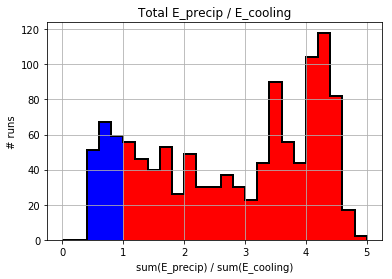

In [65]:
dfl = df05[df05['E_ex_t'] < df05['E_s_t']]
dfl['ex_s_rat'].hist(bins=np.linspace(0,5,5/.2+1), color='blue', histtype='stepfilled')
dfg = df05[df05['E_ex_t'] > df05['E_s_t']]
dfg['ex_s_rat'].hist(bins=np.linspace(0,5,5/.2+1), color='red', histtype='stepfilled')

df05['ex_s_rat'].hist(bins=np.linspace(0,5,5/.2+1), color='black', histtype='step', lw=2)
plt.plot()
plt.title('Total E_precip / E_cooling')
plt.xlabel('sum(E_precip) / sum(E_cooling)')
plt.ylabel('# runs')
plt.savefig('Histogram_of_Exsoltuions.pdf')

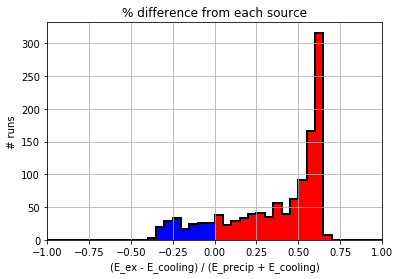

In [70]:
dfl = df05[df05['E_ex_t'] < df05['E_s_t']]
dfl['ex_s_diff'].hist(bins=np.linspace(-1,1,41), color='blue', histtype='stepfilled')
dfg = df05[df05['E_ex_t'] > df05['E_s_t']]
dfg['ex_s_diff'].hist(bins=np.linspace(-1,1,41), color='red', histtype='stepfilled')

df05['ex_s_diff'].hist(bins=np.linspace(-1,1,41), color='black', histtype='step', lw=2)

plt.xlim(-1,1)
plt.title('% difference from each source')
plt.xlabel('(E_ex - E_cooling) / (E_precip + E_cooling)')
plt.ylabel('# runs')
plt.savefig('hist_of_entropies_symmetric_scale.pdf')

# Cross-correlation of present-day core compositions

In [83]:
import matplotlib.gridspec as gridspec

In [248]:
Ts = np.array(df05['T_cmb0'])
Tnormed = np.array((Ts-np.min(Ts))/(np.max(Ts)-np.min(Ts)))

In [249]:
Tplt = np.tile(np.unique(Ts)[:,None],2)

In [250]:
Tplt.shape

(9, 2)

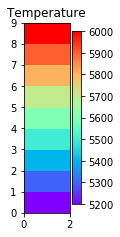

In [267]:
plt.figure(figsize=(2,3.5))
plt.pcolor(Tplt, cmap=plt.cm.rainbow)
plt.colorbar()
plt.title('Temperature')
plt.gcf().subplots_adjust(left=.2,right=.6)
plt.savefig('Temperature_colorbar.pdf')

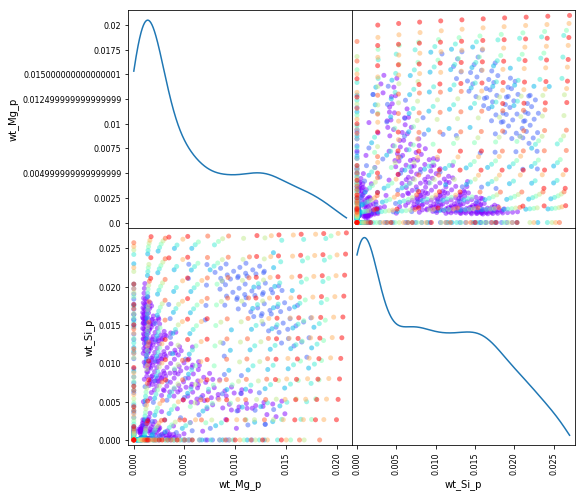

In [222]:
pd.plotting.scatter_matrix(df05[['wt_Mg_p','wt_Si_p']],color=plt.cm.rainbow(Tnormed), alpha=.5, diagonal='kde', marker='.',s=100, figsize=(8,8))
plt.savefig('MgSiDependence_TempColor_hist.pdf')

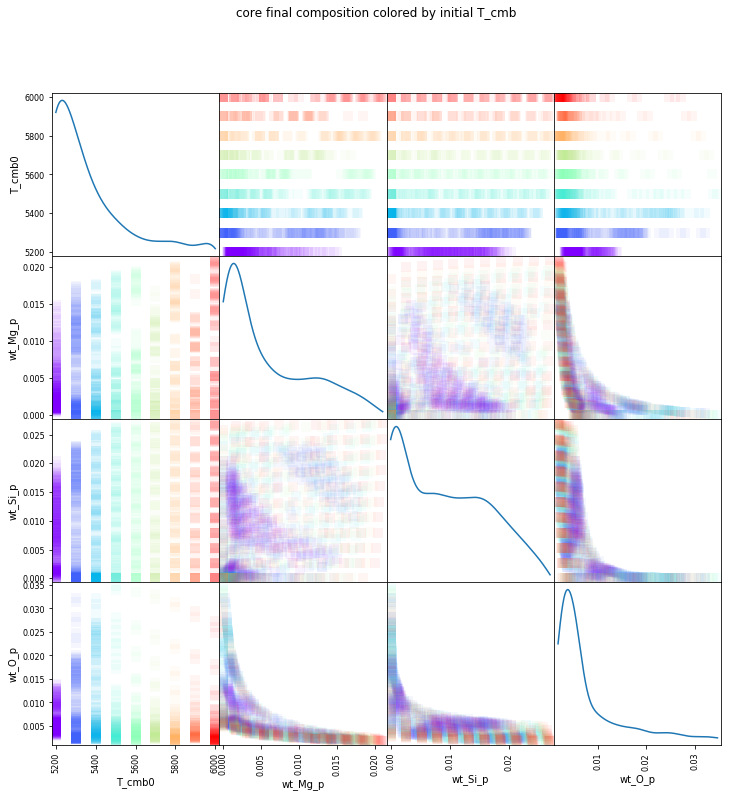

In [223]:
pd.plotting.scatter_matrix(df05[['T_cmb0','wt_Mg_p','wt_Si_p','wt_O_p']], color=plt.cm.rainbow(Tnormed), alpha=0.05, figsize=(12, 12), diagonal='kde', marker='s', s=100)
plt.suptitle('core final composition colored by initial T_cmb')
plt.savefig('core_comp_present_Tcolored_scatter.pdf')

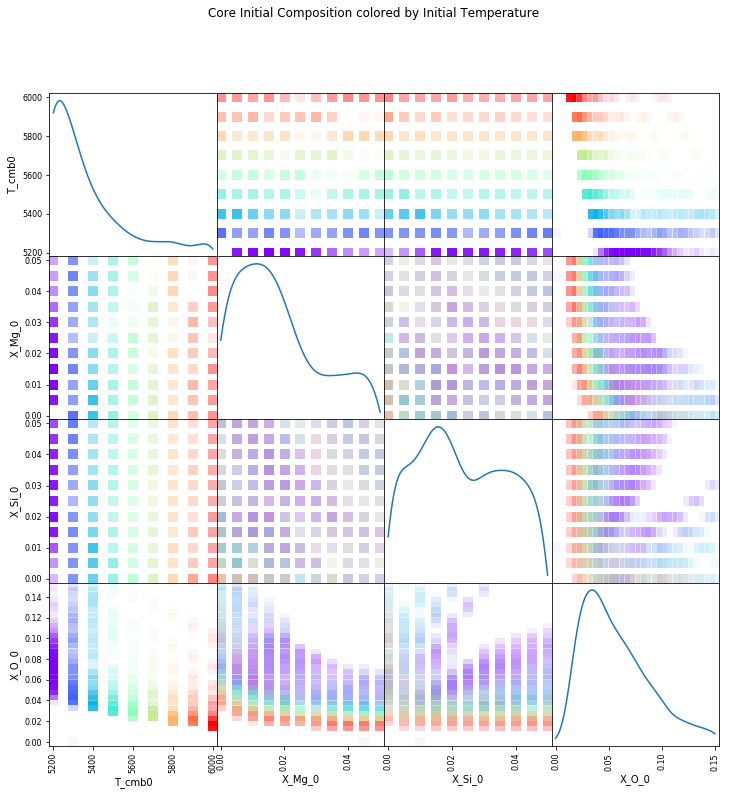

In [229]:
pd.plotting.scatter_matrix(df05[['T_cmb0','X_Mg_0','X_Si_0','X_O_0']], color=plt.cm.rainbow(Tnormed), alpha=0.05, figsize=(12, 12), diagonal='kde', marker='s', s=100)
plt.suptitle('Core Initial Composition colored by Initial Temperature')
plt.savefig('core_comp_initial_Tcolored_scatter.pdf')

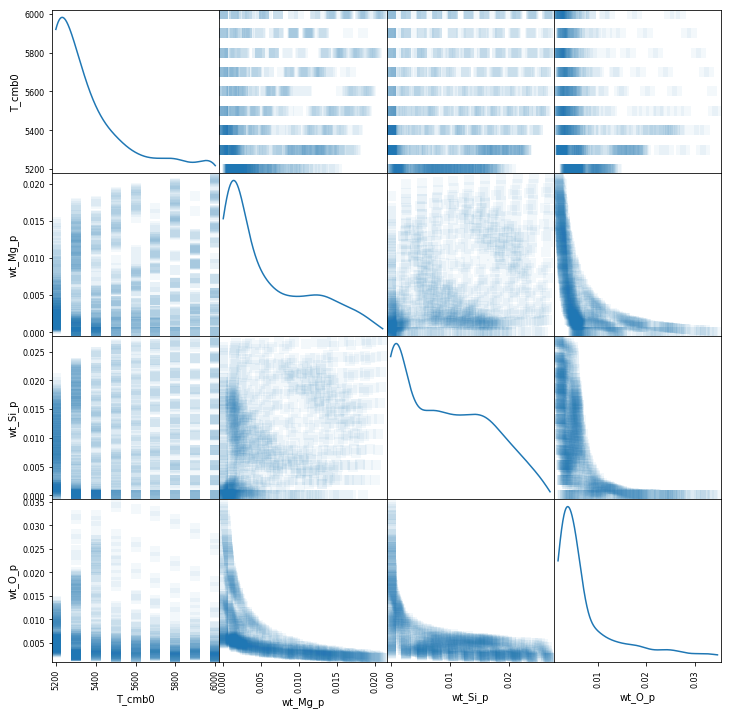

In [137]:
pd.plotting.scatter_matrix(df05[['T_cmb0','wt_Mg_p','wt_Si_p','wt_O_p']],  alpha=0.05, figsize=(12, 12), diagonal='kde', marker='s', s=100)
plt.savefig('core_comp_present_scatter.pdf')

# Oxygen at Present Colored

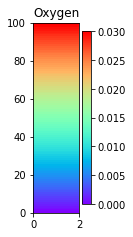

In [268]:
Ts = np.array(df05['wt_O_p'])
Omax = 0.03
Tnormed = np.array((Ts-0)/(Omax-0))

Tplt = np.tile(np.linspace(0,Omax,100)[:,None],2)

plt.figure(figsize=(2,3.5))
plt.pcolor(Tplt, cmap=plt.cm.rainbow)
plt.colorbar()
plt.title('Oxygen')
plt.gcf().subplots_adjust(left=.2,right=.6)

plt.savefig('Oxygen_colorbar.pdf')

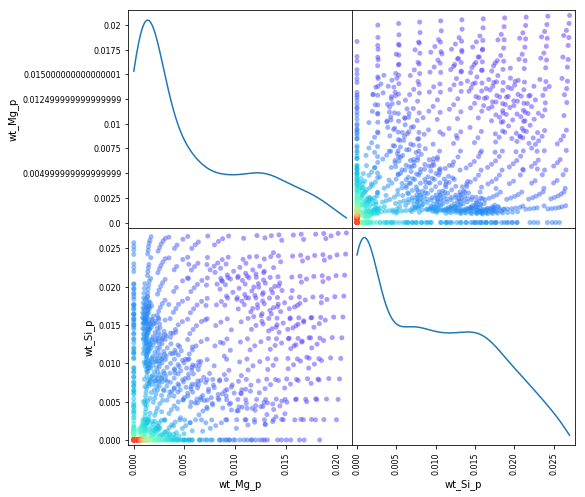

In [242]:
pd.plotting.scatter_matrix(df05[['wt_Mg_p','wt_Si_p']],color=plt.cm.rainbow(Tnormed), alpha=.5, diagonal='kde', marker='.',s=100, figsize=(8,8))
plt.savefig('MgSiDependence_OxyColor_hist.pdf')

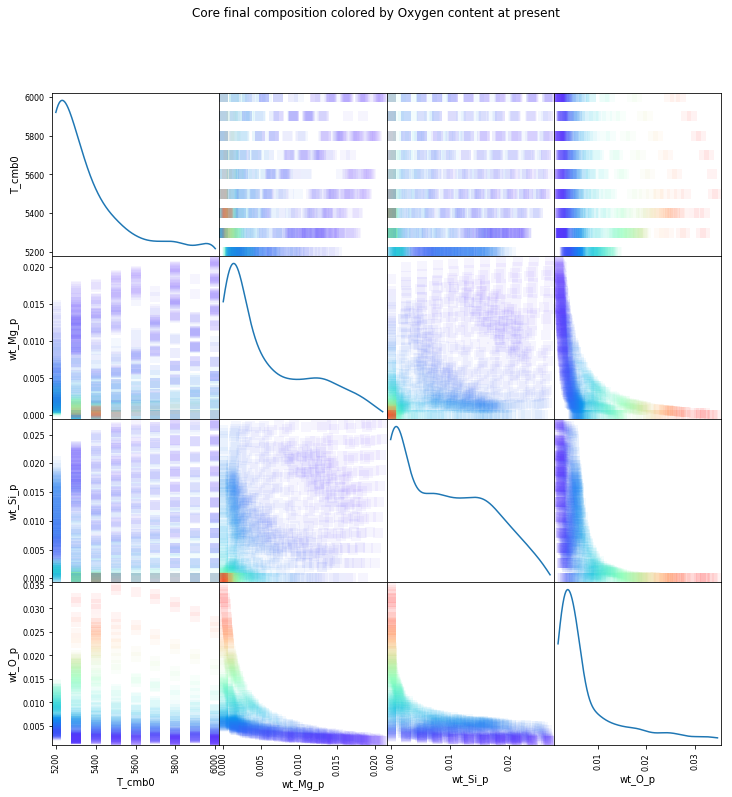

In [243]:
pd.plotting.scatter_matrix(df05[['T_cmb0','wt_Mg_p','wt_Si_p','wt_O_p']], color=plt.cm.rainbow(Tnormed), alpha=0.05, figsize=(12, 12), diagonal='kde', marker='s', s=100)
plt.suptitle('Core final composition colored by Oxygen content at present')
plt.savefig('core_comp_present_Ocolored_scatter.pdf')

In [246]:
np.linspace(.155,.25,20)

array([0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185, 0.19 , 0.195,
       0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 , 0.235, 0.24 ,
       0.245, 0.25 ])

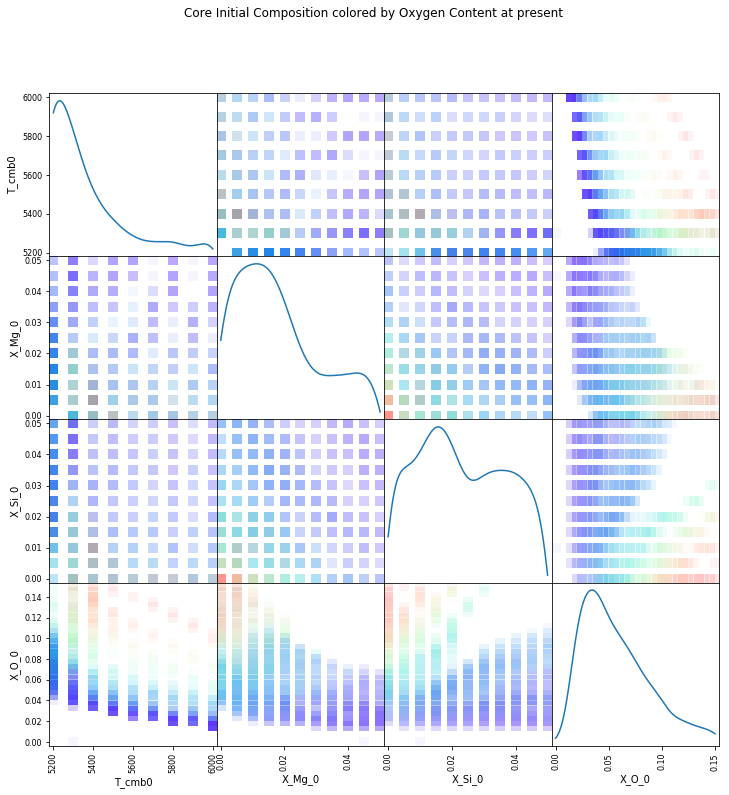

In [244]:
pd.plotting.scatter_matrix(df05[['T_cmb0','X_Mg_0','X_Si_0','X_O_0']], color=plt.cm.rainbow(Tnormed), alpha=0.05, figsize=(12, 12), diagonal='kde', marker='s', s=100)
plt.suptitle('Core Initial Composition colored by Oxygen Content at present')
plt.savefig('core_comp_initial_Ocolored_scatter.pdf')

# Initial Oxygen Colored

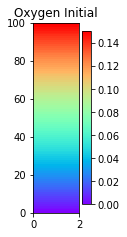

In [269]:
Ts = np.array(df05['X_O_0'])
Omax = 0.15
Tnormed = np.array((Ts-0)/(Omax-0))

Tplt = np.tile(np.linspace(0,Omax,100)[:,None],2)

plt.figure(figsize=(2,3.5))
plt.pcolor(Tplt, cmap=plt.cm.rainbow)
plt.colorbar()
plt.title('Oxygen Initial')
plt.gcf().subplots_adjust(left=.2,right=.6)

plt.savefig('OxygenInit_colorbar.pdf')

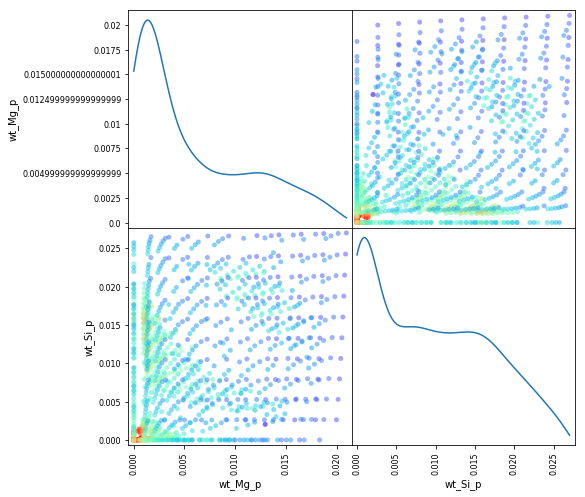

In [238]:
pd.plotting.scatter_matrix(df05[['wt_Mg_p','wt_Si_p']],color=plt.cm.rainbow(Tnormed), alpha=.5, diagonal='kde', marker='.',s=100, figsize=(8,8))
plt.savefig('MgSiDependence_OxyInitColor_hist.pdf')

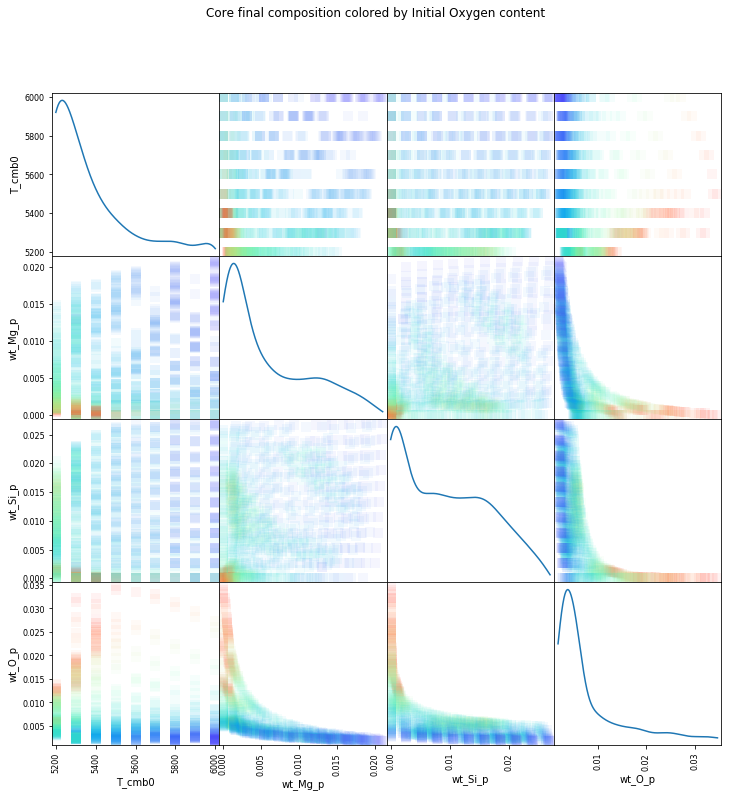

In [239]:
pd.plotting.scatter_matrix(df05[['T_cmb0','wt_Mg_p','wt_Si_p','wt_O_p']], color=plt.cm.rainbow(Tnormed), alpha=0.05, figsize=(12, 12), diagonal='kde', marker='s', s=100)
plt.suptitle('Core final composition colored by Initial Oxygen content')
plt.savefig('core_comp_present_OInitcolored_scatter.pdf')

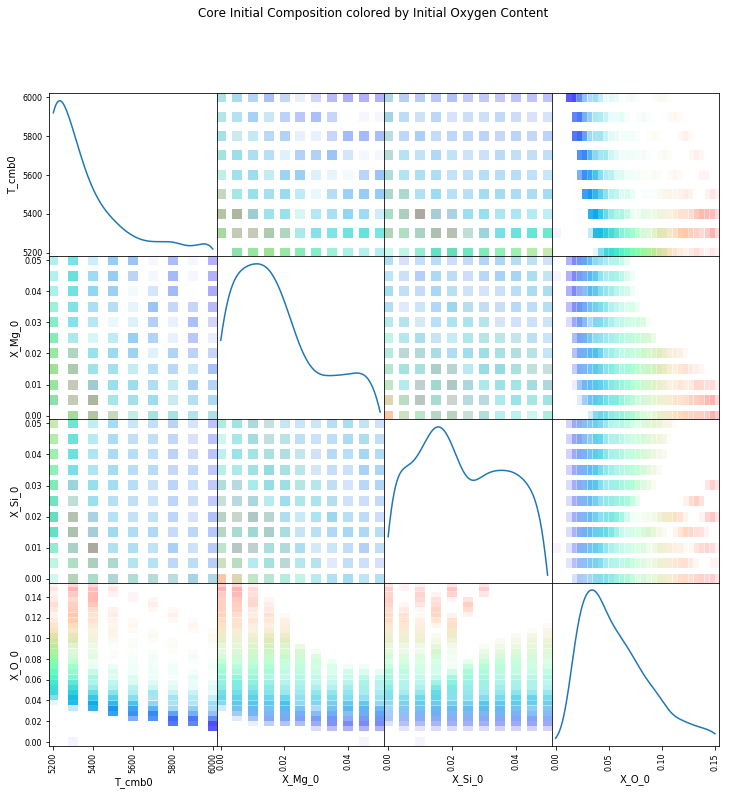

In [240]:
pd.plotting.scatter_matrix(df05[['T_cmb0','X_Mg_0','X_Si_0','X_O_0']], color=plt.cm.rainbow(Tnormed), alpha=0.05, figsize=(12, 12), diagonal='kde', marker='s', s=100)
plt.suptitle('Core Initial Composition colored by Initial Oxygen Content')
plt.savefig('core_comp_initial_OInitcolored_scatter.pdf')

# Cooling/Exsolution Colored

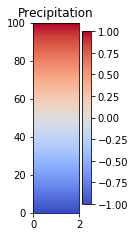

In [270]:
Ts = np.array(df05['ex_s_diff'])
Ts[np.isnan(Ts)] = -1
Tmax = 1
Tmin = -1
Tnormed = np.array((Ts-Tmin)/(Tmax-Tmin))

Tplt = np.tile(np.linspace(Tmin,Tmax,100)[:,None],2)

plt.figure(figsize=(2,3.5))
plt.pcolor(Tplt, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.title('Precipitation')
plt.gcf().subplots_adjust(left=.2,right=.6)

plt.savefig('Precipitation_colorbar.pdf')

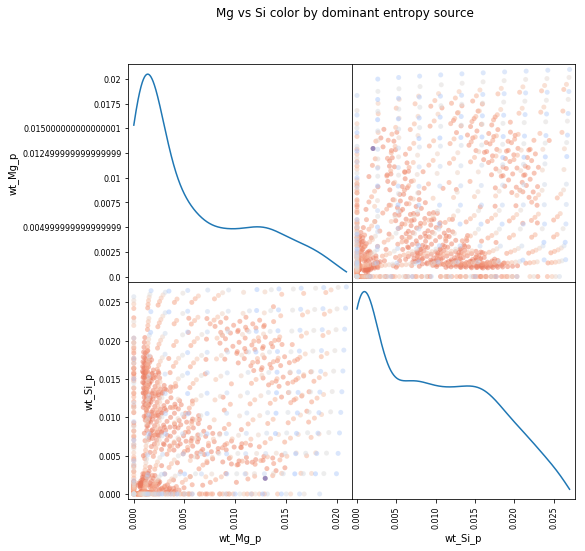

In [203]:
pd.plotting.scatter_matrix(df05[['wt_Mg_p','wt_Si_p']],color=plt.cm.coolwarm(Tnormed), alpha=.5, diagonal='kde', marker='.',s=100, figsize=(8,8))
plt.suptitle('Mg vs Si color by dominant entropy source')
plt.savefig('MgSiDependence_PrecipColor_hist.pdf')

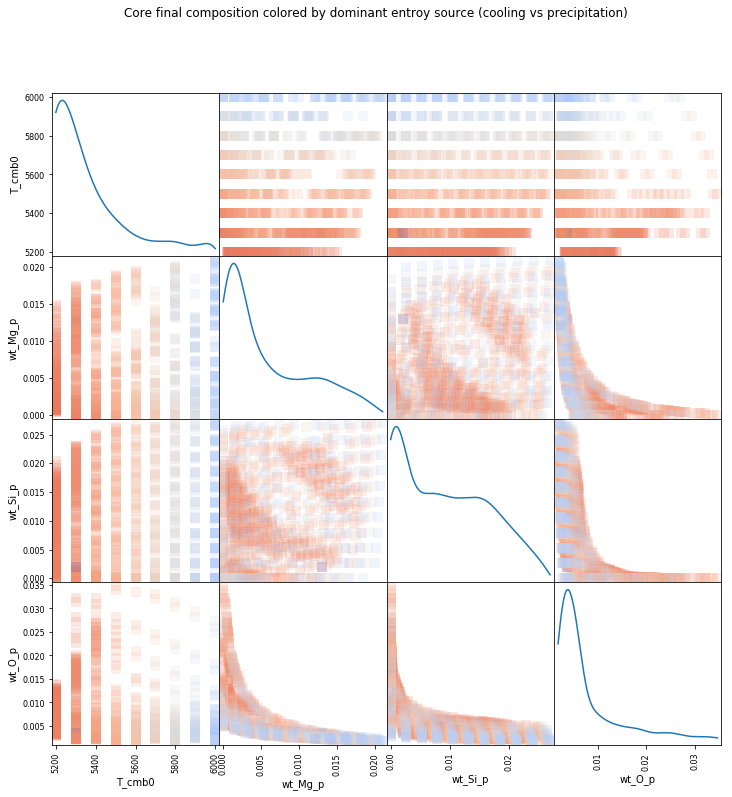

In [202]:
pd.plotting.scatter_matrix(df05[['T_cmb0','wt_Mg_p','wt_Si_p','wt_O_p']], color=plt.cm.coolwarm(Tnormed), alpha=0.2, figsize=(12, 12), diagonal='kde', marker='s', s=100)
plt.suptitle('Core final composition colored by dominant entroy source (cooling vs precipitation)')
plt.savefig('core_comp_present_Precipcolored_scatter.pdf')

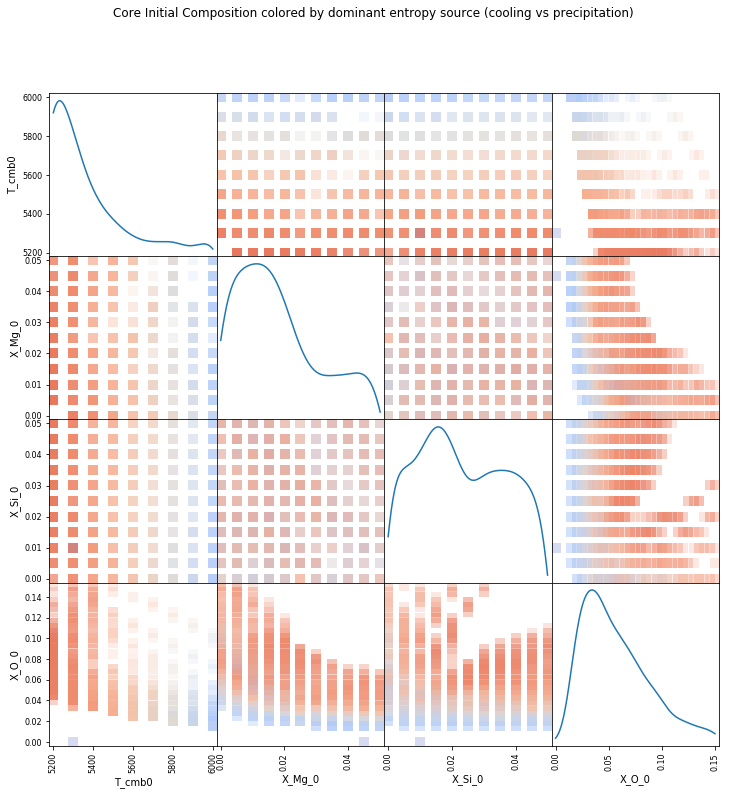

In [200]:
pd.plotting.scatter_matrix(df05[['T_cmb0','X_Mg_0','X_Si_0','X_O_0']], color=plt.cm.coolwarm(Tnormed), alpha=0.2, figsize=(12, 12), diagonal='kde', marker='s', s=100)
plt.suptitle('Core Initial Composition colored by dominant entropy source (cooling vs precipitation)')
plt.savefig('core_comp_initial_Precipcolored_scatter.pdf')

# Other Stuff

In [9]:
dfall = pd.read_csv('../computed_solutions_nature/all_data.csv', names=['time', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0', 'MgNumFp', 'MgNumPv', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present', 'deltaT0', 'layer_thickness', 'overturn'])

In [7]:
dfall['T_cmb0'].unique()

array([], dtype=object)

In [26]:
dfall.describe()

,time,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0,MgNumFp,MgNumPv,X_MgFeO_b,X_SiO2_b,nu_present,deltaT0,layer_thickness,overturn
count,0,0,0,0,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
dfall['r_i'].isnull().sum()

36322

In [31]:
dfall[dfall['T_cmb0']==6100.].describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0,MgNumFp,MgNumPv,X_MgFeO_b,X_SiO2_b,nu_present,deltaT0,layer_thickness,overturn
count,3.630000e+03,3751.0,3751.000000,3751.000000,3751.000000,3751.0,3.751000e+03,3.751000e+03,3.751000e+03,3.751000e+03,3.751000e+03,3751.0,3751.0
mean,2.396469e+05,6100.0,0.025005,0.025005,0.075005,0.8,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,2.709365e+03,100.0,600.0
std,5.036091e+05,0.0,0.015810,0.015810,0.044724,0.0,2.220742e-16,5.551855e-17,6.939819e-18,0.000000e+00,1.364424e-12,0.0,0.0
min,0.000000e+00,6100.0,0.000010,0.000010,0.000010,0.8,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,2.709365e+03,100.0,600.0
25%,0.000000e+00,6100.0,0.010008,0.010008,0.035008,0.8,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,2.709365e+03,100.0,600.0
50%,0.000000e+00,6100.0,0.025005,0.025005,0.075005,0.8,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,2.709365e+03,100.0,600.0
75%,0.000000e+00,6100.0,0.040002,0.040002,0.115002,0.8,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,2.709365e+03,100.0,600.0
max,1.547258e+06,6100.0,0.050000,0.050000,0.150000,0.8,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,2.709365e+03,100.0,600.0


# Play with valid solutions within 5%, Tc<6000K

In [44]:
df05l6000 = pd.read_csv('../computed_solutions_nature/ri05p_l6000K_data.csv', names=['time', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0', 'MgNumFp', 'MgNumPv', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present', 'deltaT0', 'layer_thickness', 'overturn'])

In [45]:
df05l6000.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0,MgNumFp,MgNumPv,X_MgFeO_b,X_SiO2_b,nu_present,deltaT0,layer_thickness,overturn
count,1.136000e+03,1136.000000,1136.000000,1136.000000,1136.000000,1.136000e+03,1136.00,1136.000,1136.000,1.136000e+03,1136.000000,1136.0,1136.0
mean,1.219885e+06,5462.764085,0.021001,0.024217,0.057541,8.000000e-01,0.93,0.311,0.015,2.000000e+17,2445.348851,100.0,600.0
std,3.474008e+04,258.792385,0.015206,0.015745,0.031039,1.110712e-16,0.00,0.000,0.000,0.000000e+00,107.221443,0.0,0.0
min,1.159210e+06,5200.000000,0.000010,0.000010,0.000010,8.000000e-01,0.93,0.311,0.015,2.000000e+17,2336.481875,100.0,600.0
25%,1.190873e+06,5200.000000,0.010008,0.010008,0.035008,8.000000e-01,0.93,0.311,0.015,2.000000e+17,2336.481875,100.0,600.0
50%,1.219391e+06,5400.000000,0.020006,0.025005,0.050007,8.000000e-01,0.93,0.311,0.015,2.000000e+17,2419.344779,100.0,600.0
75%,1.249598e+06,5700.000000,0.035003,0.040002,0.075005,8.000000e-01,0.93,0.311,0.015,2.000000e+17,2543.639135,100.0,600.0
max,1.280979e+06,6000.000000,0.050000,0.050000,0.150000,8.000000e-01,0.93,0.311,0.015,2.000000e+17,2667.933491,100.0,600.0


# Play with valid solutions within 5%

In [32]:
df05 = pd.read_csv('../computed_solutions_nature/ri05p_data.csv', names=['time', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0', 'MgNumFp', 'MgNumPv', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present', 'deltaT0', 'layer_thickness', 'overturn'])

In [33]:
df05.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0,MgNumFp,MgNumPv,X_MgFeO_b,X_SiO2_b,nu_present,deltaT0,layer_thickness,overturn
count,1.581000e+03,1581.000000,1581.000000,1581.000000,1581.000000,1.581000e+03,1.581000e+03,1581.000,1.581000e+03,1.581000e+03,1581.000000,1581.0,1581.0
mean,1.222629e+06,5694.876660,0.020015,0.023516,0.045848,8.000000e-01,9.300000e-01,0.311,1.500000e-02,2.000000e+17,2541.516461,100.0,600.0
std,3.477201e+04,436.186365,0.015344,0.015989,0.032944,1.110574e-16,1.110574e-16,0.000,3.470545e-18,0.000000e+00,180.718344,0.0,0.0
min,1.159210e+06,5200.000000,0.000010,0.000010,0.000010,8.000000e-01,9.300000e-01,0.311,1.500000e-02,2.000000e+17,2336.481875,100.0,600.0
25%,1.192282e+06,5300.000000,0.005009,0.010008,0.020009,8.000000e-01,9.300000e-01,0.311,1.500000e-02,2.000000e+17,2377.913327,100.0,600.0
50%,1.224863e+06,5600.000000,0.015007,0.025005,0.040007,8.000000e-01,9.300000e-01,0.311,1.500000e-02,2.000000e+17,2502.207683,100.0,600.0
75%,1.255407e+06,6100.000000,0.030004,0.035003,0.065006,8.000000e-01,9.300000e-01,0.311,1.500000e-02,2.000000e+17,2709.364943,100.0,600.0
max,1.280979e+06,6400.000000,0.050000,0.050000,0.150000,8.000000e-01,9.300000e-01,0.311,1.500000e-02,2.000000e+17,2833.659299,100.0,600.0


In [34]:
df05['T_cmb0'].unique()

array([5200., 5300., 5400., 5500., 5600., 5700., 5800., 5900., 6000.,
       6100., 6200., 6300., 6400.])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76e7e1e470>]],
      dtype=object)

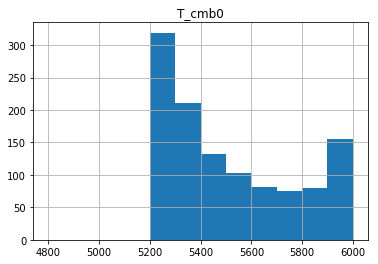

In [35]:
df05.hist('T_cmb0',bins=np.linspace(4800,6000,13))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76e759d588>]],
      dtype=object)

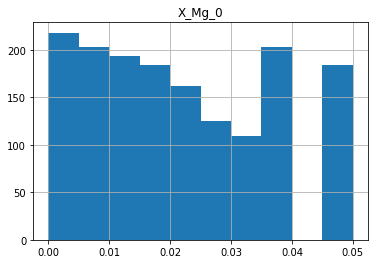

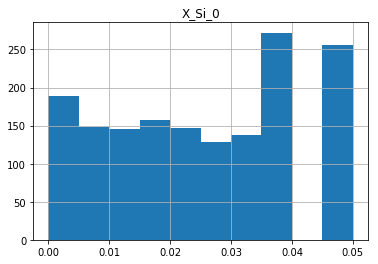

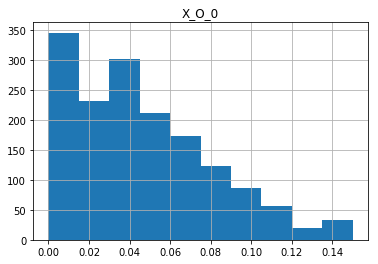

In [36]:
df05.hist('X_Mg_0')
df05.hist('X_Si_0')
df05.hist('X_O_0')

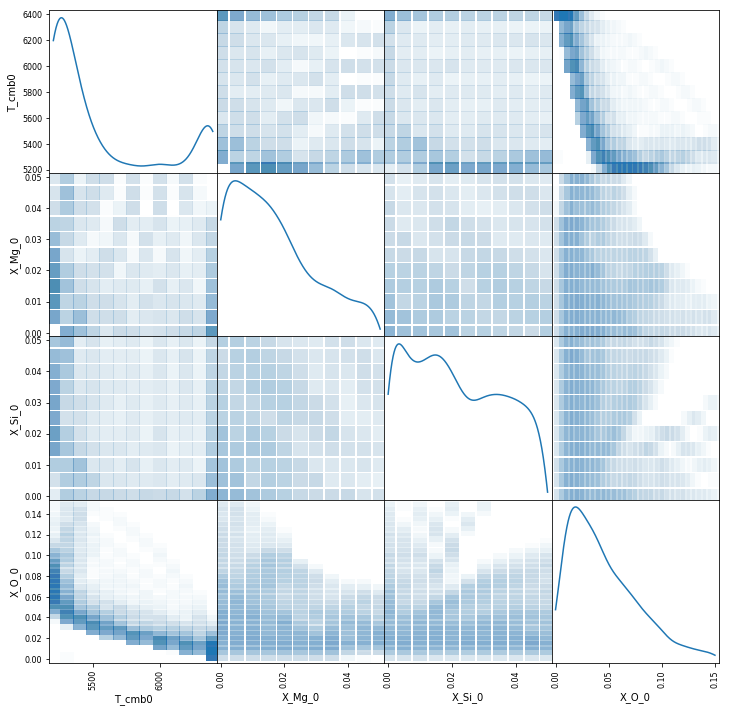

In [37]:
pd.plotting.scatter_matrix(df05[['T_cmb0','X_Mg_0','X_Si_0','X_O_0']], alpha=0.02, figsize=(12, 12), diagonal='kde', marker='s', s=200)
plt.savefig('ri05p_scatter_matrix.pdf')

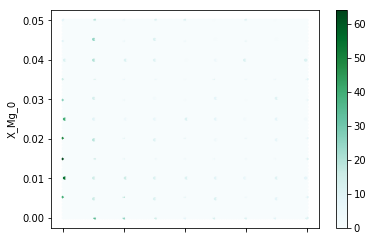

In [24]:
df05.plot(kind='hexbin', x='T_cmb0',y='X_Mg_0',)

# Play with valid solutions within 10%

In [38]:
df10 = pd.read_csv('../computed_solutions_nature/ri10p_data.csv', names=['time', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0', 'MgNumFp', 'MgNumPv', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present', 'deltaT0', 'layer_thickness', 'overturn'])

In [39]:
df10.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0,MgNumFp,MgNumPv,X_MgFeO_b,X_SiO2_b,nu_present,deltaT0,layer_thickness,overturn
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.0,3.226000e+03,3226.000,3.226000e+03,3.226000e+03,3226.000000,3226.0,3226.0
mean,1.215967e+06,5705.300682,0.020300,0.023359,0.046052,0.8,9.300000e-01,0.311,1.500000e-02,2.000000e+17,2545.835284,100.0,600.0
std,6.902868e+04,449.633566,0.015286,0.016116,0.034177,0.0,2.220790e-16,0.000,5.204977e-18,0.000000e+00,186.289715,0.0,0.0
min,1.098003e+06,5100.000000,0.000010,0.000010,0.000010,0.8,9.300000e-01,0.311,1.500000e-02,2.000000e+17,2295.050423,100.0,600.0
25%,1.150611e+06,5300.000000,0.005009,0.010008,0.020009,0.8,9.300000e-01,0.311,1.500000e-02,2.000000e+17,2377.913327,100.0,600.0
50%,1.216580e+06,5600.000000,0.020006,0.020006,0.035008,0.8,9.300000e-01,0.311,1.500000e-02,2.000000e+17,2502.207683,100.0,600.0
75%,1.270553e+06,6100.000000,0.030004,0.035003,0.065006,0.8,9.300000e-01,0.311,1.500000e-02,2.000000e+17,2709.364943,100.0,600.0
max,1.341970e+06,6500.000000,0.050000,0.050000,0.150000,0.8,9.300000e-01,0.311,1.500000e-02,2.000000e+17,2875.090751,100.0,600.0


In [40]:
df10['T_cmb0'].unique()

array([5100., 5200., 5300., 5400., 5500., 5600., 5700., 5800., 5900.,
       6000., 6100., 6200., 6300., 6400., 6500.])

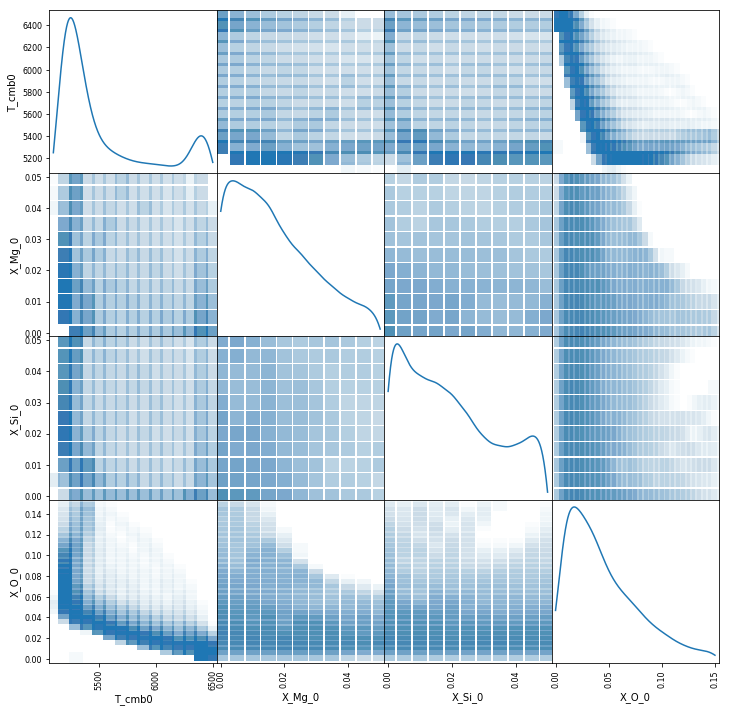

In [41]:
pd.plotting.scatter_matrix(df10[['T_cmb0','X_Mg_0','X_Si_0','X_O_0']], alpha=0.02, figsize=(12, 12), diagonal='kde', marker='s', s=200)
plt.savefig('ri10p_scatter_matrix.pdf')